## <font color='blue'>0. Load data</font>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

import time
import sys
import os

sys.path.append('./src')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score

In [7]:
# read Bike Sharing data
path = './data/TCGA/'
df = pd.read_csv(path + "TCGA_skcm.csv")

data = df.iloc[:,1:]
orig_headers = list(data)
outcome_header = "OS_STATUS"

feature_names = list(data)
feature_names.remove(outcome_header)

one_vars = np.where(np.array([len(np.unique(x)) for x in np.array(data).T])==1)[0]
for i in [orig_headers[i] for i in one_vars]:
    feature_names.remove(i)
    
Xo = data[feature_names].values
y = data[outcome_header].values


cate_vars = np.where((np.array([len(np.unique(x)) for x in np.array(Xo).T])<=12) &
                    (np.array([len(np.unique(x)) for x in np.array(Xo).T])>2))[0]
cont_vars = np.where((np.array([len(np.unique(x)) for x in np.array(Xo).T])>12) |
                    (np.array([len(np.unique(x)) for x in np.array(Xo).T])<=2))[0]
cate_vars = np.setdiff1d(cate_vars,[10])
cate_vars = np.sort(np.append(cate_vars,27))
cont_vars = np.setdiff1d(cont_vars,[27])
cont_vars = np.sort(np.append(cont_vars,10))

X_cate = Xo[:,cate_vars]
X_cont = Xo[:,cont_vars]
names_cont = [feature_names[i] for i in cont_vars]
names_cate = [feature_names[i] for i in cate_vars] 


X_cont_min, X_cont_max = X_cont.min(axis=0), X_cont.max(axis=0)
X_cont = (X_cont-X_cont_min)/(X_cont_max - X_cont_min + 1e-9)
    
df_cate = [pd.get_dummies(Xo[:,i], drop_first=True).values for i in cate_vars]
X_cate = np.hstack(df_cate)
a = sum([list(np.repeat(names_cate[i],j)) for i,j in enumerate([x.shape[1] for x in df_cate])],[])
b = sum([list(range(i)) for i in [x.shape[1] for x in df_cate]],[])
names_cate = ['{}{}'.format(a[i],b[i]) for i in range(len(b))]     
    
X = np.hstack([X_cont,X_cate])
feature_names = sum([names_cont,names_cate],[]) 


print(X.shape, y.shape, len(feature_names))
list(zip(feature_names,[len(np.unique(X[:,i])) for i in range(X.shape[1])]))

(388, 73) (388,) 73


[('AGE', 69),
 ('DAYS_TO_COLLECTION', 357),
 ('ETHNICITY', 2),
 ('FORM_COMPLETION_DATE', 104),
 ('FRACTION_GENOME_ALTERED', 372),
 ('HISTORY_NEOADJUVANT_TRTYN', 2),
 ('HISTORY_OTHER_MALIGNANCY', 2),
 ('ICD_10', 39),
 ('ICD_O_3_HISTOLOGY', 10),
 ('ICD_O_3_SITE', 35),
 ('INITIAL_PATHOLOGIC_DX_YEAR', 31),
 ('NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 2),
 ('OCT_EMBEDDED', 2),
 ('OS_MONTHS', 368),
 ('PRIMARY_MELANOMA_KNOWN_DX', 2),
 ('PROSPECTIVE_COLLECTION', 2),
 ('RADIATION_TREATMENT_ADJUVANT', 2),
 ('RETROSPECTIVE_COLLECTION', 2),
 ('SAMPLE_COUNT', 2),
 ('SAMPLE_INITIAL_WEIGHT', 76),
 ('SAMPLE_TYPE', 2),
 ('SAMPLE_TYPE_ID', 2),
 ('SEX', 2),
 ('SUBMITTED_TUMOR_DX_DAYS_TO', 260),
 ('VIAL_NUMBER', 2),
 ('AJCC_NODES_PATHOLOGIC_PN0', 2),
 ('AJCC_NODES_PATHOLOGIC_PN1', 2),
 ('AJCC_NODES_PATHOLOGIC_PN2', 2),
 ('AJCC_NODES_PATHOLOGIC_PN3', 2),
 ('AJCC_NODES_PATHOLOGIC_PN4', 2),
 ('AJCC_NODES_PATHOLOGIC_PN5', 2),
 ('AJCC_NODES_PATHOLOGIC_PN6', 2),
 ('AJCC_NODES_PATHOLOGIC_PN7', 2),
 ('AJCC_NODES_

In [70]:
Xoo = np.hstack([Xo[:,cont_vars],X_cate])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## <font color='blue'>1. EDA</font>

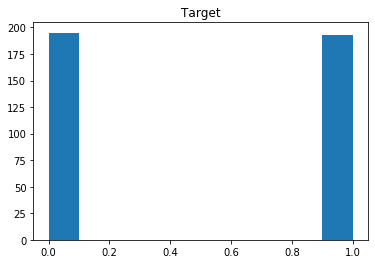

In [10]:
_ = plt.hist(y, bins='auto')  # arguments are passed to np.histogram
plt.title("Target")
plt.show()

In [11]:
N = X_train.shape[0]
p = X_train.shape[1]
print('N:{}, p:{}'.format(N,p))

N:310, p:73


## <font color='blue'>2. Fit DNN model</font>

### 2-1. Generate tensor slices

In [29]:
tf.random.set_seed(1)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(10).repeat()
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

### 2-2. Model specification

In [30]:
dnn_model = tf.keras.Sequential(
        [
        tf.keras.layers.Input(shape=(X_train.shape[1],), name='input'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )

In [31]:
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               18944     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 27,201
Trainable params: 27,201
Non-trainable params: 0
_________________________________________________________________


### 2-3. Set model optimization hyperparameters

In [32]:
dnn_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(name='loss'),
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='acc')]
)    

### 2-4 Fit DNN

In [33]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
    
history = dnn_model.fit(train_ds,
                        epochs=EPOCHS,
                        steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=(X_test, y_test))

Epoch 1/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5589 - acc: 0.7120 - val_loss: 0.6454 - val_acc: 0.6538
Epoch 2/10
200/200 [==============================] - 0s 953us/step - loss: 0.3577 - acc: 0.8500 - val_loss: 0.6738 - val_acc: 0.6410
Epoch 3/10
200/200 [==============================] - 0s 964us/step - loss: 0.2181 - acc: 0.9210 - val_loss: 0.7140 - val_acc: 0.7436
Epoch 4/10
200/200 [==============================] - 0s 993us/step - loss: 0.1309 - acc: 0.9620 - val_loss: 0.7893 - val_acc: 0.7821
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.1081 - acc: 0.9620 - val_loss: 0.9773 - val_acc: 0.7308
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0764 - acc: 0.9735 - val_loss: 1.0163 - val_acc: 0.7692
Epoch 7/10
200/200 [==============================] - 0s 981us/step - loss: 0.0595 - acc: 0.9805 - val_loss: 1.0183 - val_acc: 0.7821
Epoch 8/10
200/200 [==============================] - 0s 964us/step 

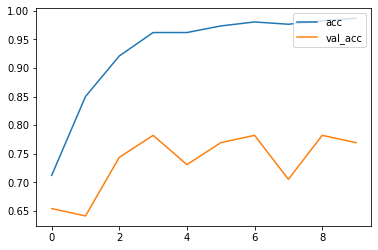

In [34]:
plt.plot(history.history['acc'], label="acc")
plt.plot(history.history['val_acc'], label="val_acc")
plt.legend(loc="upper right")
plt.show()

In [36]:
pred_dnn_train = np.round(dnn_model.predict(X_train))
pred_dnn_test = np.round(dnn_model.predict(X_test))
print('Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            roc_auc_score(y_train,pred_dnn_train),
            roc_auc_score(y_test,pred_dnn_test)))

Train RMSE:0.987 / Test RMSE:0.777


## <font color='blue'>3. Mixture Linear Model</font>

In [37]:
import mixturelinearmodel
from mixturelinearmodel import MixtureLinearModel

In [38]:
MLM = MixtureLinearModel(dnn_model, verbose=True)

In [39]:
MLM.compute_CELL(X_train,K=13,random_seed=1)

100%|██████████| 2/2 [00:00<00:00,  8.38it/s]

# of CELL:77 / min size:1 / avg size:4.0 / max size:15 / # of singlton CELL:22


In [40]:
# fit MLM-cell
MLM.fit_LocalModels(X_train, y_train, 
                    eps=0.1, num_noise_samp=100, 
                    classification=True, alpha=0.1, max_iter=10000, random_seed=1)

  1%|▏         | 1/77 [00:02<03:06,  2.46s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1154488088660373
            Iterations: 406
            Function evaluations: 407
            Gradient evaluations: 406


  3%|▎         | 2/77 [00:04<02:56,  2.35s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1115622348594662
            Iterations: 377
            Function evaluations: 378
            Gradient evaluations: 377


  4%|▍         | 3/77 [00:06<02:52,  2.33s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07916343978924967
            Iterations: 354
            Function evaluations: 354
            Gradient evaluations: 354


  5%|▌         | 4/77 [00:09<03:01,  2.48s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11323120705831588
            Iterations: 443
            Function evaluations: 443
            Gradient evaluations: 443


  6%|▋         | 5/77 [00:12<03:01,  2.52s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10276827885056751
            Iterations: 415
            Function evaluations: 415
            Gradient evaluations: 415


  8%|▊         | 6/77 [00:14<03:02,  2.57s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12357757610898279
            Iterations: 427
            Function evaluations: 428
            Gradient evaluations: 427


  9%|▉         | 7/77 [00:17<02:51,  2.45s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11478301895544898
            Iterations: 377
            Function evaluations: 377
            Gradient evaluations: 377


 10%|█         | 8/77 [00:19<02:46,  2.42s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10188495758716778
            Iterations: 381
            Function evaluations: 381
            Gradient evaluations: 381


 12%|█▏        | 9/77 [00:21<02:40,  2.35s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10427613173167605
            Iterations: 350
            Function evaluations: 350
            Gradient evaluations: 350


 13%|█▎        | 10/77 [00:24<02:38,  2.37s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10888321919329381
            Iterations: 389
            Function evaluations: 389
            Gradient evaluations: 389


 14%|█▍        | 11/77 [00:26<02:35,  2.35s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11180647375105489
            Iterations: 367
            Function evaluations: 368
            Gradient evaluations: 367


 16%|█▌        | 12/77 [00:28<02:28,  2.29s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07653586823365632
            Iterations: 346
            Function evaluations: 347
            Gradient evaluations: 346


 17%|█▋        | 13/77 [00:30<02:27,  2.30s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11880480632987857
            Iterations: 381
            Function evaluations: 382
            Gradient evaluations: 381


 18%|█▊        | 14/77 [00:33<02:32,  2.43s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11462704647280395
            Iterations: 398
            Function evaluations: 398
            Gradient evaluations: 398


 19%|█▉        | 15/77 [00:36<02:31,  2.44s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11175149107190772
            Iterations: 391
            Function evaluations: 392
            Gradient evaluations: 391


 21%|██        | 16/77 [00:38<02:28,  2.43s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10544187334207122
            Iterations: 398
            Function evaluations: 399
            Gradient evaluations: 398


 22%|██▏       | 17/77 [00:41<02:27,  2.47s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11547531750551346
            Iterations: 419
            Function evaluations: 420
            Gradient evaluations: 419


 23%|██▎       | 18/77 [00:43<02:21,  2.39s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0770909692705542
            Iterations: 359
            Function evaluations: 359
            Gradient evaluations: 359


 25%|██▍       | 19/77 [00:45<02:19,  2.40s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11840585356230353
            Iterations: 396
            Function evaluations: 397
            Gradient evaluations: 396


 26%|██▌       | 20/77 [00:48<02:27,  2.58s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11837775187787986
            Iterations: 461
            Function evaluations: 461
            Gradient evaluations: 461


 27%|██▋       | 21/77 [00:51<02:29,  2.67s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05723811069341166
            Iterations: 354
            Function evaluations: 354
            Gradient evaluations: 354


 29%|██▊       | 22/77 [00:54<02:27,  2.69s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11787779021316665
            Iterations: 401
            Function evaluations: 402
            Gradient evaluations: 401


 30%|██▉       | 23/77 [00:56<02:17,  2.55s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09494625472820008
            Iterations: 358
            Function evaluations: 358
            Gradient evaluations: 358


 31%|███       | 24/77 [00:58<02:10,  2.47s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10818220142251456
            Iterations: 374
            Function evaluations: 375
            Gradient evaluations: 374


 32%|███▏      | 25/77 [01:01<02:09,  2.48s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11906324452081027
            Iterations: 418
            Function evaluations: 418
            Gradient evaluations: 418


 34%|███▍      | 26/77 [01:03<02:04,  2.44s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10593926535144432
            Iterations: 358
            Function evaluations: 359
            Gradient evaluations: 358


 35%|███▌      | 27/77 [01:06<02:03,  2.47s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07893179246055648
            Iterations: 386
            Function evaluations: 386
            Gradient evaluations: 386


 36%|███▋      | 28/77 [01:08<02:02,  2.50s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11295384162944158
            Iterations: 420
            Function evaluations: 420
            Gradient evaluations: 420


 38%|███▊      | 29/77 [01:11<02:01,  2.53s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11608522913791319
            Iterations: 428
            Function evaluations: 428
            Gradient evaluations: 428


 39%|███▉      | 30/77 [01:13<01:54,  2.44s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07408165713997336
            Iterations: 368
            Function evaluations: 368
            Gradient evaluations: 368


 40%|████      | 31/77 [01:16<01:52,  2.44s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08713967092837638
            Iterations: 396
            Function evaluations: 397
            Gradient evaluations: 396


 42%|████▏     | 32/77 [01:18<01:45,  2.35s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11041818361616602
            Iterations: 360
            Function evaluations: 360
            Gradient evaluations: 360


 43%|████▎     | 33/77 [01:21<01:52,  2.56s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12028696993912637
            Iterations: 439
            Function evaluations: 439
            Gradient evaluations: 439


 44%|████▍     | 34/77 [01:23<01:50,  2.56s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13911773539706923
            Iterations: 390
            Function evaluations: 390
            Gradient evaluations: 390


 45%|████▌     | 35/77 [01:25<01:42,  2.44s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06783687874764177
            Iterations: 351
            Function evaluations: 351
            Gradient evaluations: 351


 47%|████▋     | 36/77 [01:28<01:42,  2.51s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10912545872134656
            Iterations: 445
            Function evaluations: 445
            Gradient evaluations: 445


 48%|████▊     | 37/77 [01:30<01:38,  2.46s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10979566057164375
            Iterations: 384
            Function evaluations: 384
            Gradient evaluations: 384


 49%|████▉     | 38/77 [01:33<01:32,  2.38s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12905007969862262
            Iterations: 365
            Function evaluations: 366
            Gradient evaluations: 365


 51%|█████     | 39/77 [01:35<01:33,  2.46s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10415871748192886
            Iterations: 402
            Function evaluations: 403
            Gradient evaluations: 402


 52%|█████▏    | 40/77 [01:38<01:30,  2.44s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10186662968002481
            Iterations: 367
            Function evaluations: 367
            Gradient evaluations: 367


 53%|█████▎    | 41/77 [01:40<01:26,  2.41s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07746421559290023
            Iterations: 373
            Function evaluations: 373
            Gradient evaluations: 373


 55%|█████▍    | 42/77 [01:43<01:26,  2.46s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11289830818467811
            Iterations: 425
            Function evaluations: 425
            Gradient evaluations: 425


 56%|█████▌    | 43/77 [01:45<01:25,  2.51s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1469802343533525
            Iterations: 433
            Function evaluations: 433
            Gradient evaluations: 433


 57%|█████▋    | 44/77 [01:48<01:22,  2.51s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08881779150827562
            Iterations: 411
            Function evaluations: 412
            Gradient evaluations: 411


 58%|█████▊    | 45/77 [01:50<01:19,  2.48s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1346357653381228
            Iterations: 401
            Function evaluations: 402
            Gradient evaluations: 401


 60%|█████▉    | 46/77 [01:53<01:21,  2.62s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12281719509587155
            Iterations: 436
            Function evaluations: 436
            Gradient evaluations: 436


 61%|██████    | 47/77 [01:55<01:16,  2.56s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1300876862855463
            Iterations: 383
            Function evaluations: 384
            Gradient evaluations: 383


 62%|██████▏   | 48/77 [01:58<01:11,  2.47s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11703743875392716
            Iterations: 383
            Function evaluations: 384
            Gradient evaluations: 383


 64%|██████▎   | 49/77 [02:00<01:06,  2.39s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09422812537743717
            Iterations: 356
            Function evaluations: 357
            Gradient evaluations: 356


 65%|██████▍   | 50/77 [02:02<01:00,  2.23s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07136564573319609
            Iterations: 305
            Function evaluations: 305
            Gradient evaluations: 305


 66%|██████▌   | 51/77 [02:04<00:56,  2.19s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11849816523772871
            Iterations: 350
            Function evaluations: 350
            Gradient evaluations: 350


 68%|██████▊   | 52/77 [02:06<00:55,  2.21s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1018287074401448
            Iterations: 369
            Function evaluations: 369
            Gradient evaluations: 369


 69%|██████▉   | 53/77 [02:09<00:55,  2.33s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0775989851918501
            Iterations: 369
            Function evaluations: 370
            Gradient evaluations: 369


 70%|███████   | 54/77 [02:11<00:54,  2.36s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1095126626705296
            Iterations: 388
            Function evaluations: 388
            Gradient evaluations: 388


 71%|███████▏  | 55/77 [02:13<00:49,  2.25s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04858067762941776
            Iterations: 317
            Function evaluations: 318
            Gradient evaluations: 317


 73%|███████▎  | 56/77 [02:16<00:49,  2.36s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08060371116299268
            Iterations: 426
            Function evaluations: 426
            Gradient evaluations: 426


 74%|███████▍  | 57/77 [02:18<00:47,  2.39s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1121377871820933
            Iterations: 404
            Function evaluations: 404
            Gradient evaluations: 404


 75%|███████▌  | 58/77 [02:20<00:43,  2.28s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05211399296928844
            Iterations: 325
            Function evaluations: 325
            Gradient evaluations: 325


 77%|███████▋  | 59/77 [02:23<00:42,  2.35s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11254630807527621
            Iterations: 403
            Function evaluations: 404
            Gradient evaluations: 403


 78%|███████▊  | 60/77 [02:26<00:41,  2.47s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10266887644386398
            Iterations: 415
            Function evaluations: 416
            Gradient evaluations: 415


 79%|███████▉  | 61/77 [02:28<00:38,  2.42s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10061000218563933
            Iterations: 370
            Function evaluations: 370
            Gradient evaluations: 370


 81%|████████  | 62/77 [02:30<00:35,  2.36s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08218461440733531
            Iterations: 363
            Function evaluations: 363
            Gradient evaluations: 363


 82%|████████▏ | 63/77 [02:33<00:33,  2.40s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12133533357924439
            Iterations: 419
            Function evaluations: 419
            Gradient evaluations: 419


 83%|████████▎ | 64/77 [02:35<00:31,  2.43s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11938093731059485
            Iterations: 410
            Function evaluations: 411
            Gradient evaluations: 410


 84%|████████▍ | 65/77 [02:37<00:28,  2.37s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11443652925189418
            Iterations: 365
            Function evaluations: 365
            Gradient evaluations: 365


 86%|████████▌ | 66/77 [02:40<00:27,  2.48s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08713150282318233
            Iterations: 387
            Function evaluations: 387
            Gradient evaluations: 387


 87%|████████▋ | 67/77 [02:43<00:25,  2.50s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1278473161933919
            Iterations: 411
            Function evaluations: 412
            Gradient evaluations: 411


 88%|████████▊ | 68/77 [02:45<00:21,  2.43s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11251575168974363
            Iterations: 370
            Function evaluations: 371
            Gradient evaluations: 370


 90%|████████▉ | 69/77 [02:47<00:19,  2.48s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10041912415442537
            Iterations: 433
            Function evaluations: 434
            Gradient evaluations: 433


 91%|█████████ | 70/77 [02:50<00:17,  2.46s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11231891241215104
            Iterations: 398
            Function evaluations: 398
            Gradient evaluations: 398


 92%|█████████▏| 71/77 [02:52<00:14,  2.48s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11036724962050438
            Iterations: 418
            Function evaluations: 419
            Gradient evaluations: 418


 94%|█████████▎| 72/77 [02:55<00:12,  2.44s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11793234455103853
            Iterations: 374
            Function evaluations: 375
            Gradient evaluations: 374


 95%|█████████▍| 73/77 [02:59<00:11,  2.85s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11731459820003284
            Iterations: 482
            Function evaluations: 483
            Gradient evaluations: 482


 96%|█████████▌| 74/77 [03:01<00:08,  2.72s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1292254732133731
            Iterations: 398
            Function evaluations: 398
            Gradient evaluations: 398


 97%|█████████▋| 75/77 [03:03<00:05,  2.53s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05582152425111572
            Iterations: 337
            Function evaluations: 338
            Gradient evaluations: 337


 99%|█████████▊| 76/77 [03:06<00:02,  2.54s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09609441790427711
            Iterations: 428
            Function evaluations: 428
            Gradient evaluations: 428


100%|██████████| 77/77 [03:08<00:00,  2.45s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11680184049813375
            Iterations: 414
            Function evaluations: 414
            Gradient evaluations: 414


In [41]:
pred_lmm_train = np.round(MLM.predict(X_train))
pred_lmm_test = np.round(MLM.predict(X_test))

100%|██████████| 77/77 [00:00<00:00, 389.61it/s]


In [43]:
print('MLM-CELL: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            roc_auc_score(y_train,np.array(pred_lmm_train)),
            roc_auc_score(y_test,np.array(pred_lmm_test))))

MLM-CELL: Train RMSE:0.948 / Test RMSE:0.728


In [44]:
# fit MLM-EPIC
MLM.fit_MergedLocalModels(10, classification=True, alpha=0.1, max_iter=10000, random_seed=1,verbose=True)

100%|██████████| 77/77 [00:00<00:00, 140.60it/s]
./src\mixturelinearmodel.py:392: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
 10%|█         | 1/10 [00:03<00:32,  3.62s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09785115526250754
            Iterations: 577
            Function evaluations: 577
            Gradient evaluations: 577


 20%|██        | 2/10 [00:06<00:27,  3.44s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06723369201376594
            Iterations: 466
            Function evaluations: 467
            Gradient evaluations: 466


 30%|███       | 3/10 [00:09<00:22,  3.28s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10828798929346822
            Iterations: 436
            Function evaluations: 437
            Gradient evaluations: 436


 40%|████      | 4/10 [00:12<00:19,  3.29s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13133369766307668
            Iterations: 532
            Function evaluations: 532
            Gradient evaluations: 532


 50%|█████     | 5/10 [00:15<00:16,  3.22s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05668913152997961
            Iterations: 454
            Function evaluations: 454
            Gradient evaluations: 454


 60%|██████    | 6/10 [00:18<00:12,  3.11s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12900200335461304
            Iterations: 450
            Function evaluations: 451
            Gradient evaluations: 450


 70%|███████   | 7/10 [00:21<00:09,  3.14s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11263199011703887
            Iterations: 515
            Function evaluations: 515
            Gradient evaluations: 515


 80%|████████  | 8/10 [00:25<00:06,  3.21s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.16440932623348414
            Iterations: 527
            Function evaluations: 527
            Gradient evaluations: 527


 90%|█████████ | 9/10 [00:28<00:03,  3.31s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11657176543155769
            Iterations: 559
            Function evaluations: 559
            Gradient evaluations: 559


C:\Users\bsseo\anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 74 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\bsseo\anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
100%|██████████| 10/10 [00:32<00:00,  3.29s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.17244770878374768
            Iterations: 647
            Function evaluations: 647
            Gradient evaluations: 647


In [45]:
pred_epic_train = np.round(MLM.predict(X_train,  merged=True, covariance_type='full', covariance_tied=False, uniform_prior=False))
pred_epic_test = np.round(MLM.predict(X_test, merged=True, covariance_type='full', covariance_tied=False, uniform_prior=False))

100%|██████████| 10/10 [00:00<00:00, 54.02it/s]


In [46]:
print('MLM-EPIC: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            roc_auc_score(y_train,np.array(pred_epic_train)),
            roc_auc_score(y_test,np.array(pred_epic_test))))

MLM-EPIC: Train RMSE:0.862 / Test RMSE:0.743


In [47]:
MLM.save_dict('./output/mlm_skcm')

---

## <font color='blue'>4. Interpretation</font>

### <font color='orange'>4-1. regression coefficients</font>

In [54]:
import utils
import importlib
importlib.reload(utils)
import utils
from utils import plot_mosaic, plot_ci, explainable_tree, explainable_condition, explainable_dim, highest_explainable_dim, plot_id_1d, plot_id_2d, plot_id_3d

In [55]:
from utils import plot_mosaic, plot_ci, explainable_tree, explainable_condition, explainable_dim, highest_explainable_dim, plot_id_1d, plot_id_2d, plot_id_3d

In [56]:
pred_epic_train = MLM.predict(X_train,  merged=True, covariance_type='full', covariance_tied=False, uniform_prior=False)

100%|██████████| 10/10 [00:00<00:00, 42.31it/s]


In [57]:
MLM.feature_names = feature_names

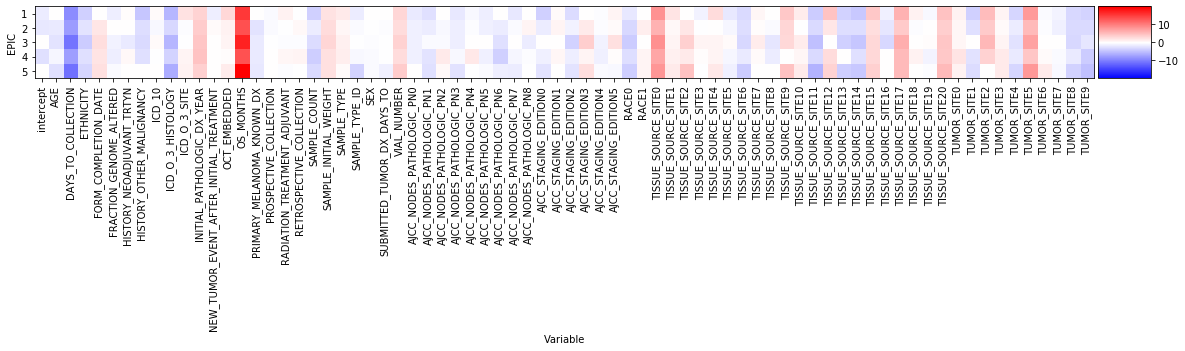

In [59]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_mosaic(MLM, epic_id=range(5), log_trans=False, ax=ax)

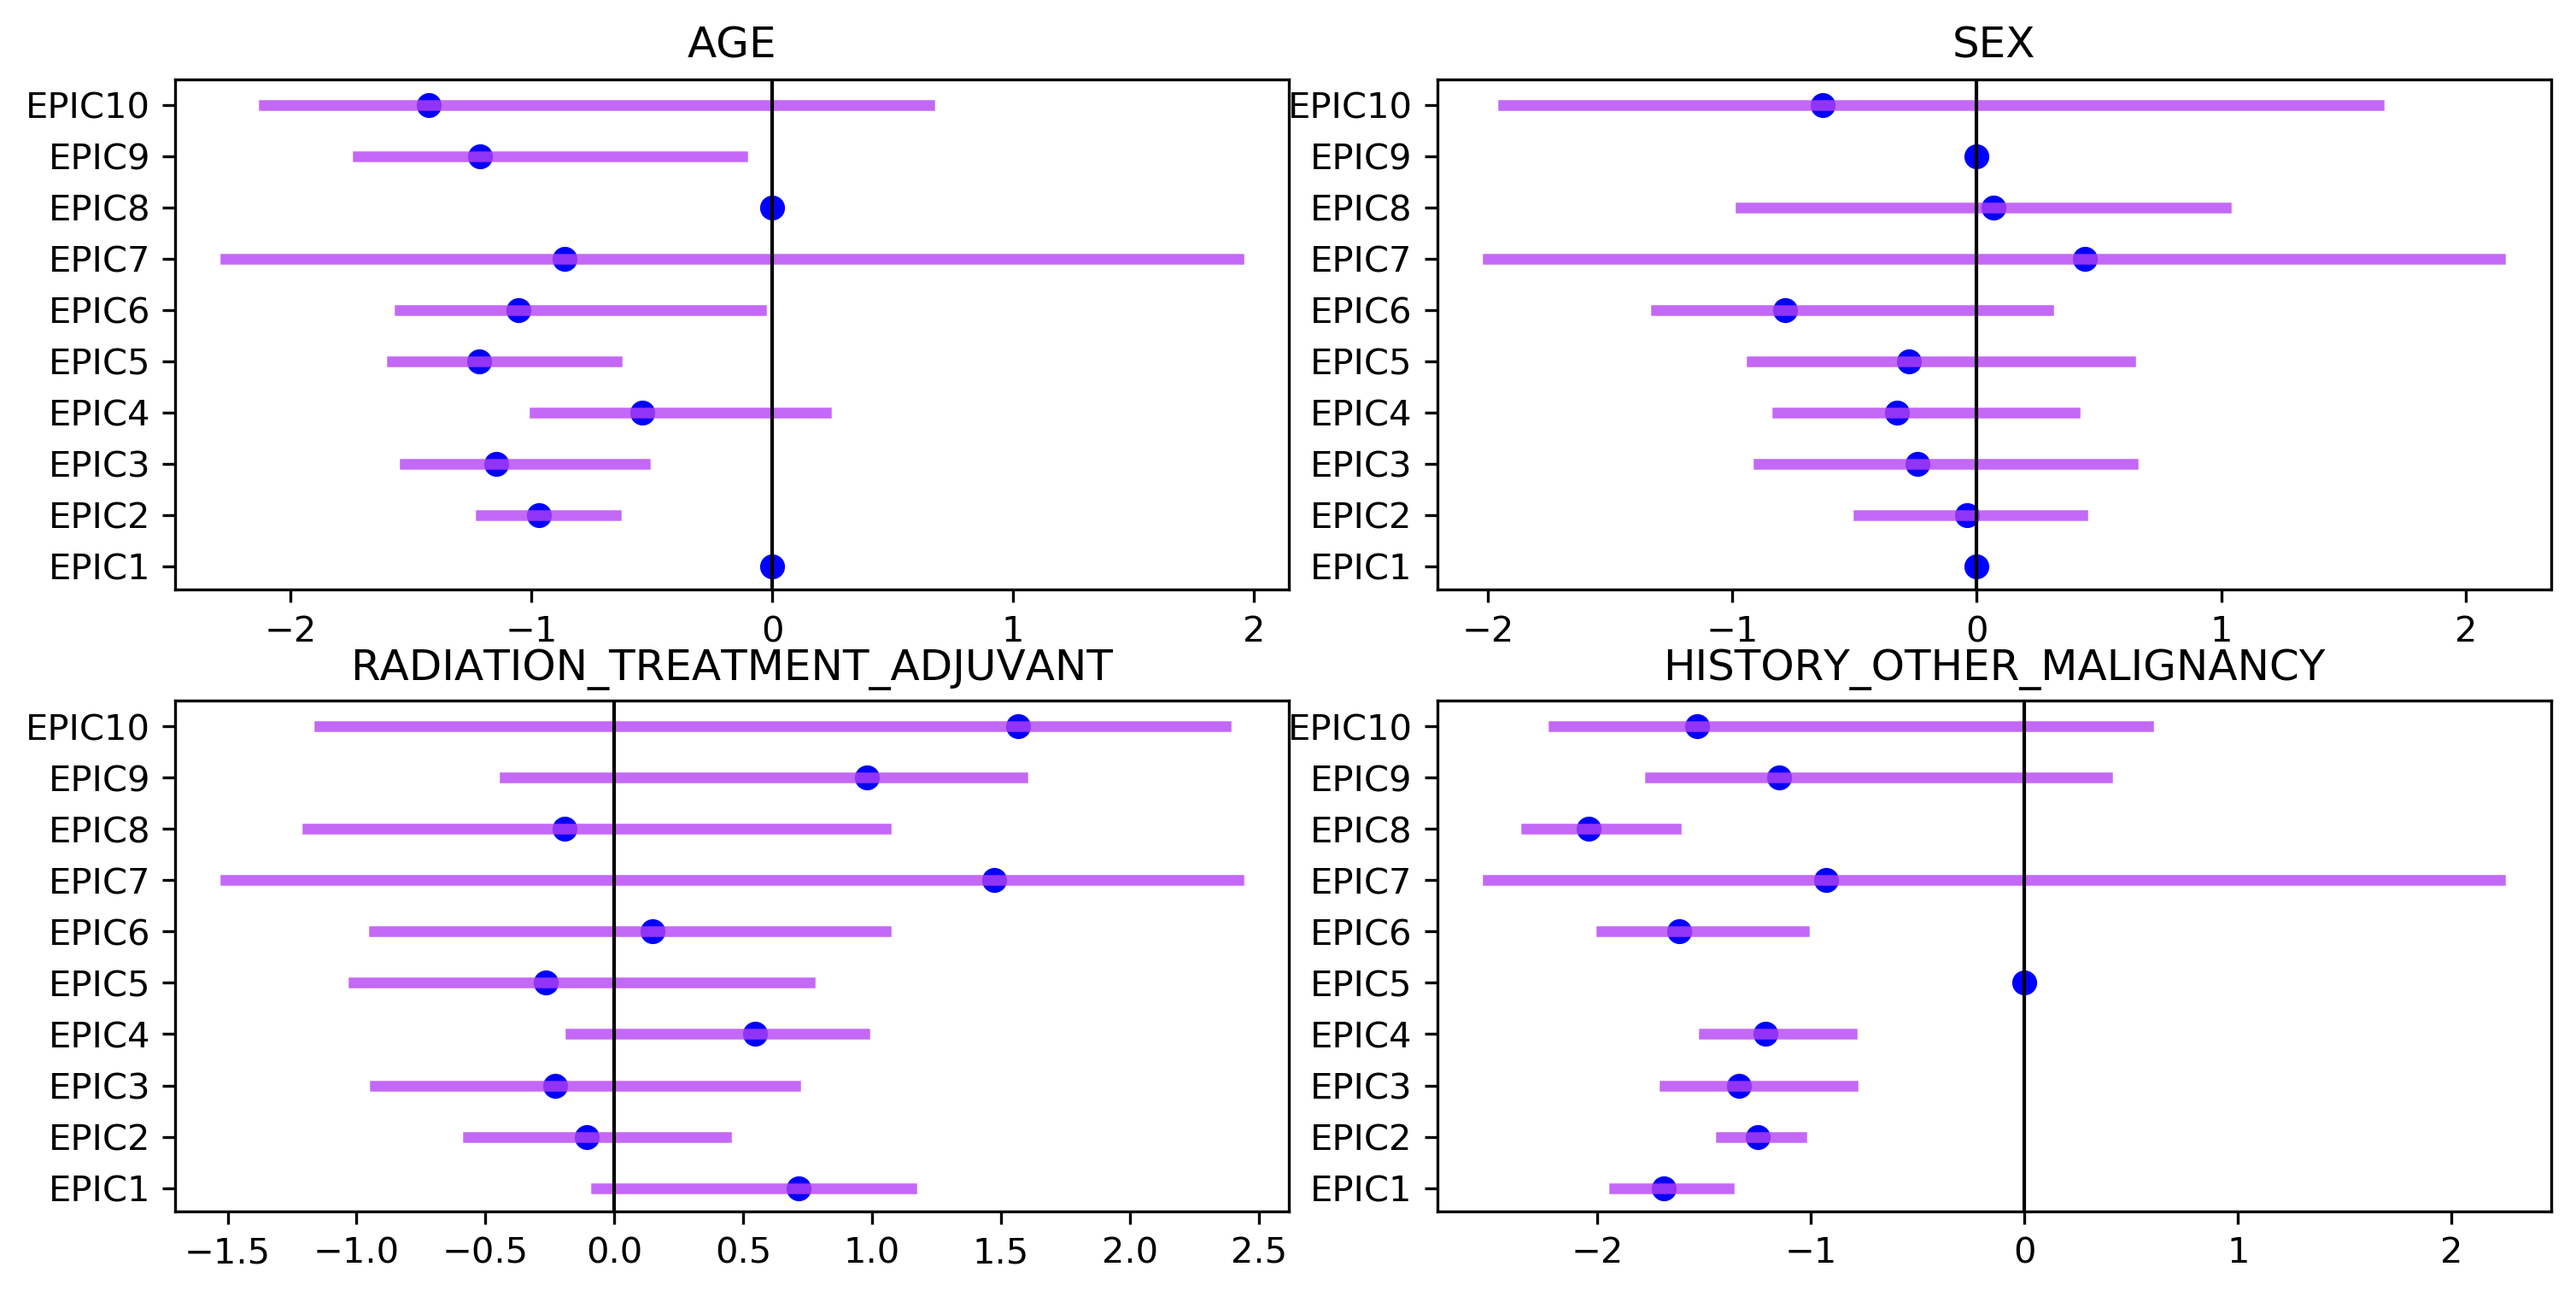

In [66]:
f, axs = plt.subplots(2,2,figsize=(10,5),dpi=300)
f.tight_layout()
for i in range(4):
    j = (1,23,17,7)[i]
    ax = plt.subplot(2,2,i+1)
    plot_ci(MLM,j,epic_id=range(10),ax=ax,title=True)

### <font color='orange'>4-2. Low Dimensional Subspace</font>

In [67]:
explainable_tree(MLM, X_train, psi=1, epic_id=range(5))

EPIC 0(orig id 3): found tree with max pure size 11 and total pure size 59 for 59
EPIC 1(orig id 9): found tree with max pure size 12 and total pure size 54 for 54
EPIC 2(orig id 6): found tree with max pure size 11 and total pure size 46 for 46
EPIC 3(orig id 7): found tree with max pure size 9 and total pure size 43 for 43
EPIC 4(orig id 0): found tree with max pure size 6 and total pure size 32 for 32


In [71]:
exp_cond = explainable_condition(MLM, Xoo, xi=5, epic_id=range(5), origin_scale=True)

In [72]:
exp_cond

[[array([['7', 'AGE <= 29.0'],
         ['7', 'DAYS_TO_COLLECTION <= 10345.0'],
         ['7', 'ICD_10 <= 5.0'],
         ['7', 'ICD_O_3_SITE > 23.5'],
         ['7', 'OS_MONTHS <= 306.2'],
         ['7', 'RETROSPECTIVE_COLLECTION > 1.5'],
         ['7', 'AJCC_STAGING_EDITION5 != 1']], dtype='<U30'),
  array([['8', 'AGE <= 29.0'],
         ['8', 'DAYS_TO_COLLECTION <= 8701.0'],
         ['8', 'DAYS_TO_COLLECTION > 10345.0'],
         ['8', 'INITIAL_PATHOLOGIC_DX_YEAR > 1996.5'],
         ['8', 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT > 1.5'],
         ['8', 'OS_MONTHS <= 306.2'],
         ['8', 'RETROSPECTIVE_COLLECTION > 1.5'],
         ['8', 'SUBMITTED_TUMOR_DX_DAYS_TO > 9737.0'],
         ['8', 'AJCC_STAGING_EDITION5 != 1']], dtype='<U45'),
  array([['11', 'AGE <= 29.0'],
         ['11', 'DAYS_TO_COLLECTION > 10345.0'],
         ['11', 'INITIAL_PATHOLOGIC_DX_YEAR > 1996.5'],
         ['11', 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT > 1.5'],
         ['11', 'OS_MONTHS <= 306.2'],
    

### <font color='orange'>4-3. Prominent Region </font>

In [75]:
explainable_dim(MLM,X_train,threshold=0.8,epic_id=range(5),max_dim=p)

  7%|▋         | 5/73 [00:00<00:01, 49.74it/s]

[[3 47 21
  (50, 6, 32, 53, 35, 55, 0, 47, 13, 69, 27, 7, 3, 51, 33, 34, 2, 39, 5, 24, 41, 31, 48, 20, 67, 54, 23, 16, 52, 15, 21, 26, 60, 71, 8, 42, 44, 59, 10, 62, 68, 72, 18, 57, 28, 1, 22, 63)
  0.8141592920353983]]


 16%|█▋        | 12/73 [00:00<00:01, 57.13it/s]

[[9 27 9
  (43, 58, 2, 3, 36, 50, 37, 6, 70, 26, 12, 35, 8, 33, 42, 29, 51, 17, 25, 24, 1, 19, 13, 59, 72, 30, 49, 16)
  0.8037383177570094]
 [9 27 11
  (43, 58, 2, 3, 36, 50, 37, 6, 70, 26, 12, 35, 8, 33, 42, 29, 51, 17, 25, 24, 1, 19, 13, 59, 72, 30, 49, 20)
  0.8037383177570094]]


  8%|▊         | 6/73 [00:00<00:01, 55.22it/s]

[[6 20 37
  (68, 0, 14, 39, 59, 27, 62, 20, 11, 5, 16, 6, 26, 18, 41, 45, 15, 2, 48, 37, 54)
  0.8048780487804877]]


 10%|▉         | 7/73 [00:00<00:01, 60.51it/s]

[[7 15 12 (49, 14, 0, 46, 41, 15, 70, 38, 32, 34, 21, 33, 9, 30, 66, 16)
  0.810126582278481]
 [7 15 21 (49, 14, 0, 46, 41, 15, 70, 38, 32, 34, 21, 33, 9, 30, 66, 26)
  0.810126582278481]
 [7 15 36 (49, 14, 0, 46, 41, 15, 70, 38, 32, 34, 21, 33, 9, 30, 66, 48)
  0.810126582278481]]


100%|██████████| 53/53 [00:03<00:00, 15.49it/s]

[[0 20 50
  (6, 59, 37, 67, 13, 26, 10, 32, 19, 5, 21, 16, 11, 66, 8, 39, 50, 63, 9, 22, 70)
  0.8070175438596492]]


In [76]:
hed =[]
for i in range(5):
    hed.append(highest_explainable_dim(MLM,i))
# epic id / explainable_dim / feature_names / explainable_rate
hed

[(3,
  (50,
   6,
   32,
   53,
   35,
   55,
   0,
   47,
   13,
   69,
   27,
   7,
   3,
   51,
   33,
   34,
   2,
   39,
   5,
   24,
   41,
   31,
   48,
   20,
   67,
   54,
   23,
   16,
   52,
   15,
   21,
   26,
   60,
   71,
   8,
   42,
   44,
   59,
   10,
   62,
   68,
   72,
   18,
   57,
   28,
   1,
   22,
   63),
  ['TISSUE_SOURCE_SITE8',
   'HISTORY_OTHER_MALIGNANCY',
   'AJCC_NODES_PATHOLOGIC_PN7',
   'TISSUE_SOURCE_SITE11',
   'AJCC_STAGING_EDITION1',
   'TISSUE_SOURCE_SITE13',
   'AGE',
   'TISSUE_SOURCE_SITE5',
   'OS_MONTHS',
   'TUMOR_SITE6',
   'AJCC_NODES_PATHOLOGIC_PN2',
   'ICD_10',
   'FORM_COMPLETION_DATE',
   'TISSUE_SOURCE_SITE9',
   'AJCC_NODES_PATHOLOGIC_PN8',
   'AJCC_STAGING_EDITION0',
   'ETHNICITY',
   'AJCC_STAGING_EDITION5',
   'HISTORY_NEOADJUVANT_TRTYN',
   'VIAL_NUMBER',
   'RACE1',
   'AJCC_NODES_PATHOLOGIC_PN6',
   'TISSUE_SOURCE_SITE6',
   'SAMPLE_TYPE',
   'TUMOR_SITE4',
   'TISSUE_SOURCE_SITE12',
   'SUBMITTED_TUMOR_DX_DAYS_TO',
   'RAD